In [3]:
from pathlib import Path
from sklearn.model_selection import KFold
import shutil
from ultralytics import YOLO
import pandas as pd
import os

In [4]:
import torch
torch.backends.cudnn.benchmark = True


En este notebook vamos a realizar el entrenamiento de los modelos. Primero vamos a revisar un approach inicial con los modelos de los filtrados y no filtrados para 80 epocas. En el notebook del procesamiento intentamos hacer lo mismo pero mediante los de preprocesamiento incluido con operaciones morfologicas sobre las imagenes.

In [ ]:
from pathlib import Path

# Nombres de las clases (sin incluir background)
class_names = [
    "Vehiculos",
    "Bodegas",
    "Caminos",
    "Rios",
    "Zonas de mineria ilegal"
]

for dataset_name in ["modelo_yolov11_dataset_filtrado", "modelo_yolov11_dataset_completo"]:
    DATA_ROOT = Path(dataset_name)

    yaml_content = f"""\
        path: {DATA_ROOT.resolve()}
        train: train
        val: val
        test: test
        nc: {len(class_names)}
        names: {class_names}
        """


    yaml_path = DATA_ROOT / "dataset.yaml"
    with open(yaml_path, "w", encoding="utf-8") as f:
        f.write(yaml_content)

    print(f"✅ YAML generado en: {yaml_path}")


Realizamos la creacion de las funciones para hacer kfold y el entrenamiento inicial

In [2]:
from pathlib import Path
from sklearn.model_selection import KFold
import shutil
from ultralytics import YOLO
import pandas as pd
import random
import math 
import cv2
import numpy as np
import tqdm as tqdm
# --- 1. Funciones de Augmentación (simplificadas para K-Fold) ---
# Adaptadas de lo que normalmente se usa, para integrar fácilmente con OpenCV.
# Si tus augmentaciones originales eran más complejas, esto podría necesitar ajuste.

def augment_image_and_labels(img_path: Path, lbl_path: Path, augment_type: str):
    """
    Aplica una augmentación específica a una imagen y sus etiquetas YOLO.
    Args:
        img_path: Ruta a la imagen original.
        lbl_path: Ruta al archivo de etiquetas original.
        augment_type: Tipo de augmentación ('hflip', 'vflip', 'rot90', 'rot180', 'rot270').
    Returns:
        tuple: (augmented_image, augmented_labels_str, new_suffix)
    """
    img = cv2.imread(str(img_path))
    if img is None:
        return None, None, None # Error al cargar

    h, w = img.shape[:2]
    labels = []
    if lbl_path.exists():
        with open(lbl_path, 'r') as f:
            for line in f:
                parts = list(map(float, line.strip().split()))
                labels.append(parts)

    augmented_img = img.copy()
    augmented_labels = []
    new_suffix = ""

    if augment_type == 'hflip':
        augmented_img = cv2.flip(img, 1) # Horizontal flip
        for cls_id, x_center, y_center, bbox_w, bbox_h in labels:
            augmented_labels.append([cls_id, 1 - x_center, y_center, bbox_w, bbox_h])
        new_suffix = "_hflip"
    elif augment_type == 'vflip':
        augmented_img = cv2.flip(img, 0) # Vertical flip
        for cls_id, x_center, y_center, bbox_w, bbox_h in labels:
            augmented_labels.append([cls_id, x_center, 1 - y_center, bbox_w, bbox_h])
        new_suffix = "_vflip"
    elif augment_type.startswith('rot'):
        k = int(augment_type[3:]) // 90
        # Rotación de la imagen
        augmented_img = cv2.rotate(img, {90: cv2.ROTATE_90_CLOCKWISE, 180: cv2.ROTATE_180, 270: cv2.ROTATE_90_COUNTERCLOCKWISE}[int(augment_type[3:])])
        
        # Actualizar etiquetas para rotación
        new_h, new_w = augmented_img.shape[:2]
        
        for cls_id, x_center, y_center, bbox_w, bbox_h in labels:
            # Convertir a coordenadas absolutas
            abs_x1 = (x_center - bbox_w / 2) * w
            abs_y1 = (y_center - bbox_h / 2) * h
            abs_x2 = (x_center + bbox_w / 2) * w
            abs_y2 = (y_center + bbox_h / 2) * h

            points = np.array([[abs_x1, abs_y1], [abs_x2, abs_y1], [abs_x1, abs_y2], [abs_x2, abs_y2]])

            # Rotar puntos
            if k == 1: # 90 grados
                rotated_points = np.array([[p[1], w - p[0]] for p in points])
            elif k == 2: # 180 grados
                rotated_points = np.array([[w - p[0], h - p[1]] for p in points])
            elif k == 3: # 270 grados
                rotated_points = np.array([[h - p[1], p[0]] for p in points]) # x' = y, y' = W - x

            # Encontrar el nuevo bounding box min/max
            min_x, min_y = np.min(rotated_points, axis=0)
            max_x, max_y = np.max(rotated_points, axis=0)

            # Convertir de nuevo a coordenadas relativas al nuevo tamaño de la imagen
            new_bbox_w = (max_x - min_x) / new_w
            new_bbox_h = (max_y - min_y) / new_h
            new_x_center = (min_x + max_x) / (2 * new_w)
            new_y_center = (min_y + max_y) / (2 * new_h)
            
            # Asegurarse de que las coordenadas estén dentro de [0, 1]
            new_x_center = np.clip(new_x_center, 0, 1)
            new_y_center = np.clip(new_y_center, 0, 1)
            new_bbox_w = np.clip(new_bbox_w, 0, 1)
            new_bbox_h = np.clip(new_bbox_h, 0, 1)

            augmented_labels.append([cls_id, new_x_center, new_y_center, new_bbox_w, new_bbox_h])
        
        new_suffix = f"_rot{augment_type[3:]}"
    else:
        # Si no hay augmentación o tipo desconocido, retornar original
        return img, '\n'.join([' '.join(map(str, lbl)) for lbl in labels]), ""

    augmented_labels_str = '\n'.join([' '.join(map(str, lbl)) for lbl in augmented_labels])
    return augmented_img, augmented_labels_str, new_suffix

# --- 2. Preparación inicial (generación de YAMLs globales, si aún no existen) ---
# Esta parte genera los dataset.yaml para los datasets "finales" (ej. para entrenar un modelo final sin K-Fold)
# Asegúrate de que `modelo_yolov11_dataset_filtrado` y `modelo_yolov11_dataset_completo`
# son los directorios que ya están 'fixed' (train con augmented, val/test con originales).
# ESTA PARTE DEL CÓDIGO NO NECESITA CAMBIAR SI YA LA EJECUTASTE.
# La dejé aquí para que el script sea autocontenido.
class_names = [
    "Vehiculos",
    "Bodegas",
    "Caminos",
    "Rios",
    "Zonas de mineria ilegal"
]

for dataset_name_global in ["modelo_yolov11_dataset_filtrado", "modelo_yolov11_dataset_completo"]:
    DATA_ROOT_GLOBAL = Path(dataset_name_global)
    yaml_content_global = f"""\
path: {DATA_ROOT_GLOBAL.resolve()}
train: train
val: val
test: test
nc: {len(class_names)}
names: {class_names}
"""
    yaml_path_global = DATA_ROOT_GLOBAL / "dataset.yaml"
    with open(yaml_path_global, "w", encoding="utf-8") as f:
        f.write(yaml_content_global)
    print(f"✅ YAML global generado en: {yaml_path_global}")

# --- 3. Función de K-Fold Modificada ---

def ejecutar_kfold_yolov8(
    original_data_root: Path, # <-- Nueva entrada: Ruta a tus datos ORIGINALES (e.g., Path("data"))
    dataset_name_for_output: str, # Para el nombre de la carpeta de resultados (e.g., "modelo_yolov11_dataset_completo_kfold")
    class_names: list,
    model_weights: str = "yolov8s.pt",
    num_folds: int = 5,
    epochs: int = 40,
    batch_size: int = 16,
    img_size: int = 640,
    patience: int = 5,
    apply_augmentation: bool = True # Control para aplicar augmentación en el fold de entrenamiento
):
    """
    Ejecuta K-Fold Cross-Validation para YOLOv8, aplicando augmentación a los datos
    de entrenamiento dentro de cada fold.
    
    Args:
        original_data_root (Path): La ruta a tu directorio 'data' que contiene
                                   'Imagenes/train', 'Imagenes/val', 'Imagenes/test' con imágenes ORIGINALES.
        dataset_name_for_output (str): Nombre base para las carpetas de salida del K-Fold.
        class_names (list): Lista de nombres de clases.
        model_weights (str): Pesos iniciales del modelo YOLO.
        num_folds (int): Número de folds para K-Fold.
        epochs (int): Número de épocas para entrenar cada fold.
        batch_size (int): Tamaño del batch.
        img_size (int): Tamaño de la imagen para el entrenamiento.
        patience (int): Paciencia para Early Stopping.
        apply_augmentation (bool): Si se debe aplicar augmentación a las imágenes de entrenamiento de cada fold.
    """
    
    # Directorios de imágenes y etiquetas ORIGINALES de entrenamiento
    ORIGINAL_TRAIN_IMG_DIR = original_data_root / "Imagenes" / "train"
    ORIGINAL_TRAIN_LBL_DIR = original_data_root / "Etiquetas" / "train"

    if not ORIGINAL_TRAIN_IMG_DIR.exists():
        raise FileNotFoundError(f"❌ Directorio de imágenes ORIGINALES de entrenamiento no encontrado: {ORIGINAL_TRAIN_IMG_DIR}")
    if not ORIGINAL_TRAIN_LBL_DIR.exists():
        print(f"⚠️ Advertencia: Directorio de etiquetas ORIGINALES de entrenamiento no encontrado: {ORIGINAL_TRAIN_LBL_DIR}. Asumiendo imágenes de fondo sin etiquetas.")


    # Carpeta raíz para los resultados del K-Fold para este dataset
    CV_ROOT = Path(f"kfold_results_{dataset_name_for_output}")
    CV_ROOT.mkdir(parents=True, exist_ok=True)

    # Recopilar todas las imágenes ORIGINALES del set de entrenamiento
    all_original_train_images = sorted(list(ORIGINAL_TRAIN_IMG_DIR.glob("*.jpg")) + 
                                       list(ORIGINAL_TRAIN_IMG_DIR.glob("*.jpeg")) + 
                                       list(ORIGINAL_TRAIN_IMG_DIR.glob("*.png")))
    
    all_original_train_labels = [ORIGINAL_TRAIN_LBL_DIR / (img.stem + ".txt") for img in all_original_train_images]

    # Verificar que haya etiquetas para todas las imágenes (o crear vacías si no hay)
    for lbl_path in all_original_train_labels:
        if not lbl_path.exists():
            print(f"⚠️ Etiqueta no encontrada para {lbl_path.stem}. Creando archivo vacío.")
            lbl_path.touch() # Crear archivo de etiqueta vacío si no existe

    assert len(all_original_train_images) > 0, f"❌ No se encontraron imágenes originales en {ORIGINAL_TRAIN_IMG_DIR}"
    print(f"Encontradas {len(all_original_train_images)} imágenes ORIGINALES para el K-Fold.")

    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    results_summary = []

    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(all_original_train_images)):
        print(f"\n🔁 Entrenando fold {fold_idx + 1}/{num_folds}...")

        fold_dir = CV_ROOT / f"fold_{fold_idx}"
        
        # Directorios de salida para este fold: imágenes y etiquetas
        # Aquí es donde se mezclarán originales y aumentadas para el train,
        # y solo originales para el val del fold.
        fold_train_img_dir = fold_dir / "images" / "train"
        fold_train_lbl_dir = fold_dir / "labels" / "train"
        fold_val_img_dir = fold_dir / "images" / "val"
        fold_val_lbl_dir = fold_dir / "labels" / "val"
        
        # Limpiar y crear directorios de fold para cada iteración
        if fold_dir.exists():
            shutil.rmtree(fold_dir) # Eliminar contenido de la carpeta del fold anterior si existe
        for d in [fold_train_img_dir, fold_train_lbl_dir, fold_val_img_dir, fold_val_lbl_dir]:
            d.mkdir(parents=True, exist_ok=True)

        # Copiar imágenes ORIGINALES al set de entrenamiento del fold
        for idx in train_idx:
            img_src = all_original_train_images[idx]
            lbl_src = all_original_train_labels[idx]
            shutil.copy(str(img_src), str(fold_train_img_dir / img_src.name))
            shutil.copy(str(lbl_src), str(fold_train_lbl_dir / lbl_src.name))

        # --- APLICAR AUGMENTACIÓN SOLO A LAS IMÁGENES DE ENTRENAMIENTO DEL FOLD ---
        if apply_augmentation:
            print(f"✨ Aplicando augmentación a {len(train_idx)} imágenes de entrenamiento del fold {fold_idx + 1}...")
            # Tipos de augmentación que se aplicarán (puedes ajustar esta lista)
            augmentation_types = ['hflip', 'vflip', 'rot90', 'rot180', 'rot270'] 
            
            # Iterar sobre las imágenes originales que están en el set de entrenamiento de este fold
            for idx in tqdm(train_idx, desc=f"Augmenting train fold {fold_idx+1}"):
                original_img_path = all_original_train_images[idx]
                original_lbl_path = all_original_train_labels[idx]

                for aug_type in augmentation_types:
                    augmented_img, augmented_labels_str, suffix = augment_image_and_labels(
                        original_img_path, original_lbl_path, aug_type
                    )
                    
                    if augmented_img is not None:
                        # Guardar la imagen aumentada
                        aug_img_name = f"{original_img_path.stem}{suffix}{original_img_path.suffix}"
                        cv2.imwrite(str(fold_train_img_dir / aug_img_name), augmented_img)
                        
                        # Guardar las etiquetas aumentadas
                        aug_lbl_name = f"{original_img_path.stem}{suffix}.txt"
                        with open(fold_train_lbl_dir / aug_lbl_name, 'w') as f:
                            f.write(augmented_labels_str)

        # Copiar imágenes ORIGINALES al set de validación del fold
        for idx in val_idx:
            img_src = all_original_train_images[idx]
            lbl_src = all_original_train_labels[idx]
            shutil.copy(str(img_src), str(fold_val_img_dir / img_src.name))
            shutil.copy(str(lbl_src), str(fold_val_lbl_dir / lbl_src.name))

        # Crear dataset.yaml para este fold
        yaml_content = f"""\
path: {fold_dir.resolve()}
train: images/train
val: images/val
nc: {len(class_names)}
names: {class_names}
"""
        yaml_path = fold_dir / "dataset.yaml"
        with open(yaml_path, "w", encoding="utf-8") as f:
            f.write(yaml_content)

        run_name = f"{dataset_name_for_output}_cv_fold_{fold_idx}"
        project_dir = Path("runs/detect")
        last_ckpt = project_dir / run_name / "weights" / "last.pt"

        # Lógica de reanudación de entrenamiento
        model = YOLO(model_weights) # Siempre cargar el modelo base o el último checkpoint
        if last_ckpt.exists():
            completed_flag = (project_dir / run_name / "results.csv").exists()
            if completed_flag:
                print(f"✅ Fold {fold_idx} ya completado previamente. Saltando...")
                # Cargar el modelo para poder ejecutar model.val() y obtener métricas
                model = YOLO(str(last_ckpt)) 
            else:
                print(f"🔄 Reanudando fold {fold_idx} desde checkpoint: {last_ckpt}")
                model = YOLO(str(last_ckpt))
                model.train(
                    resume=True,
                    epochs=epochs,
                    name=run_name
                )
        else:
            print(f"🚀 Entrenando fold {fold_idx} desde cero...")
            model.train(
                data=str(yaml_path),
                epochs=epochs,
                imgsz=img_size,
                batch=batch_size,
                name=run_name,
                patience=patience
            )

        # Evaluar el modelo en el conjunto de validación de este fold
        metrics = model.val(data=str(yaml_path)).results_dict
        metrics["fold"] = fold_idx
        results_summary.append(metrics)
        
        # Opcional: Eliminar los datos temporales del fold después de entrenar para ahorrar espacio
        # shutil.rmtree(fold_dir)
        # print(f"🗑️ Eliminado directorio temporal del fold {fold_idx}.")


    df_results = pd.DataFrame(results_summary)
    csv_output = CV_ROOT / "cv_results_summary.csv"
    df_results.to_csv(csv_output, index=False)
    print(f"\n✅ Cross-validation completa. Resultados guardados en: {csv_output}")

# --- 4. Función para entrenar el Modelo Final (sin cambios significativos aquí) ---
# Esta función entrenará tu modelo final en TODO el dataset que le pases,
# incluyendo tus imágenes aumentadas en 'train' y las originales en 'val'/'test'.
# Asume que el dataset de entrada ya está en la estructura 'fixed' que discutimos.
def entrenar_modelo_final(
    dataset_name: str, # Este es el nombre del dataset ya fixed (ej., "modelo_yolov11_dataset_completo")
    class_names: list,
    model_weights: str = "yolov8s.pt",
    epochs: int = 80,
    batch_size: int = 16,
    img_size: int = 640,
    patience: int = 10
):
    DATA_ROOT = Path(dataset_name)
    FINAL_OUTPUT_DIR = Path(f"final_model_{dataset_name}")
    FINAL_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

    yaml_path = DATA_ROOT / "dataset.yaml"
    run_name = f"{dataset_name}_final"
    project_dir = Path("runs/detect")
    last_ckpt = project_dir / run_name / "weights" / "last.pt"

    if last_ckpt.exists():
        print(f"🔄 Reanudando modelo final desde checkpoint: {last_ckpt}")
        model = YOLO(str(last_ckpt))
        results = model.train(
            resume=True,
            epochs=epochs,
            name=run_name
        )
    else:
        print(f"🚀 Entrenando modelo final sobre todo el dataset: {dataset_name}...")
        model = YOLO(model_weights)
        results = model.train(
            data=str(yaml_path),
            epochs=epochs,
            imgsz=img_size,
            batch=batch_size,
            name=run_name,
            patience=patience
        )

    final_model_path = FINAL_OUTPUT_DIR / f"{dataset_name}_final_model.pt"
    # YOLO.save() guarda el modelo best.pt en la ruta especificada
    shutil.copy(project_dir / run_name / "weights" / "best.pt", final_model_path)
    print(f"\n✅ Modelo final guardado en: {final_model_path}")


def entrenar_modelo_final(
    dataset_name: str,
    class_names: list,
    model_weights: str = "yolov8s.pt",
    epochs: int = 80,
    batch_size: int = 16,
    img_size: int = 640,
    patience: int = 10
):
    DATA_ROOT = Path(dataset_name)
    FINAL_OUTPUT_DIR = Path(f"final_model_{dataset_name}")
    FINAL_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

    yaml_path = DATA_ROOT / "dataset.yaml"
    run_name = f"{dataset_name}_final"
    project_dir = Path("runs/detect")
    last_ckpt = project_dir / run_name / "weights" / "last.pt"

    if last_ckpt.exists():
        print(f"🔄 Reanudando modelo final desde checkpoint: {last_ckpt}")
        model = YOLO(str(last_ckpt))
        results = model.train(
            resume=True,
            epochs=epochs,
            name=run_name
        )
    else:
        print(f"🚀 Entrenando modelo final sobre todo el dataset: {dataset_name}...")
        model = YOLO(model_weights)
        results = model.train(
            data=str(yaml_path),
            epochs=epochs,
            imgsz=img_size,
            batch=batch_size,
            name=run_name,
            patience=patience
        )

    final_model_path = FINAL_OUTPUT_DIR / f"{dataset_name}_final_model.pt"
    model.save(str(final_model_path))
    print(f"\n✅ Modelo final guardado en: {final_model_path}")

✅ YAML global generado en: modelo_yolov11_dataset_filtrado\dataset.yaml
✅ YAML global generado en: modelo_yolov11_dataset_completo\dataset.yaml


# Entrenamiento del multiclass para dataset filtrado

Vamos a centrarnos primero en el entrenamiento kfold para filtrado y revisar sus resultados

## K-fold Filtrado

In [ ]:
ejecutar_kfold_yolov8(
    dataset_name="modelo_yolov11_dataset_filtrado",
    class_names=["Vehiculos", "Bodegas", "Caminos", "Rios", "Zonas de mineria ilegal"]
)

Los resultados en general observamos que se comportan bien para todos los folds

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('models/kfold_results_modelo_yolov11_dataset_filtrado/cv_results_summary.csv')
df

Las metricas se comportan muy parecido

## Modelo Final - Filtrado

Ahora realizamos el modelo para el filtrado

In [ ]:
entrenar_modelo_final(
    dataset_name="modelo_yolov11_dataset_filtrado",
    class_names=["Vehiculos", "Bodegas", "Caminos", "Rios", "Zonas de mineria ilegal"]
)


En general las metricas estan bastante bien para no aplicar ningun preprocesamiento a las imagenes

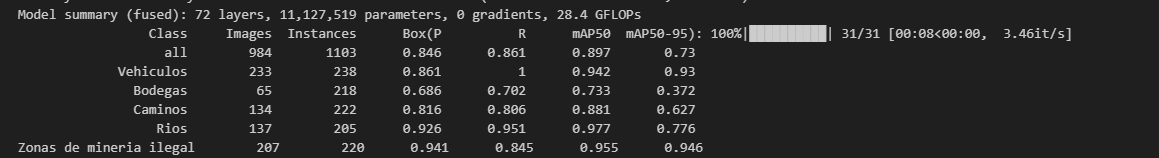

# Entrenamiento del multiclass para dataset completo

## K-fold Completo

Ahora realizamos el k-fold completo para el dataset completo

In [ ]:
ejecutar_kfold_yolov8(
    dataset_name="modelo_yolov11_dataset_completo",
    class_names=["Vehiculos", "Bodegas", "Caminos", "Rios", "Zonas de mineria ilegal"]
)

In [ ]:
df = pd.read_csv('models/kfold_results_modelo_yolov11_dataset_completo/cv_results_summary.csv')
df

En general se comportan de la misma forma

## Modelo Final - Completo

Realizamos el entrenamiento para 80 epocas

In [ ]:
entrenar_modelo_final(
    dataset_name="modelo_yolov11_dataset_completo",
    class_names=["Vehiculos", "Bodegas", "Caminos", "Rios", "Zonas de mineria ilegal"]
)


Los resultados estan un poco mejor frente al filtrado

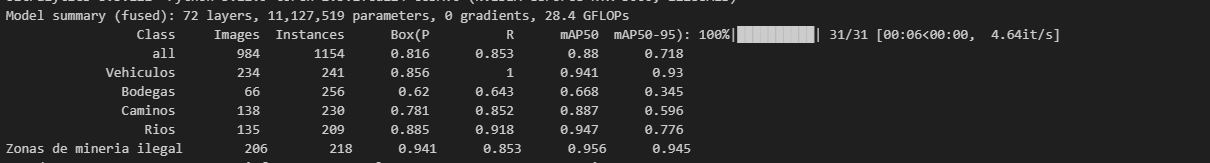

## Resultados sin fine tuning

In [ ]:
from PIL import Image as PImage
display(PImage.open('runs/detect/modelo_yolov11_dataset_completo_final2/results.png'))

display(PImage.open('runs/detect/modelo_yolov11_dataset_completo_final2/confusion_matrix.png'))

In [ ]:
from PIL import Image as PImage
display(PImage.open('runs/detect/modelo_yolov11_dataset_filtrado_final3/results.png'))

display(PImage.open('runs/detect/modelo_yolov11_dataset_filtrado_final3/confusion_matrix.png'))

# Intentando con 250 epocas

Ahora vamos a intentar mejorar aun mas los modelos, ampliandolos a 150 epocas para ver en que punto se activa el early stopping y llegar al optimo

In [6]:
def entrenar_modelo_final(
    dataset_name: str,
    class_names: list,
    model_weights: str = "yolov8s.pt",
    epochs: int = 250,
    batch_size: int = 16,
    img_size: int = 640,
    patience: int = 10,
    output_name: str = "final_model",
    resume_from_ckpt: str = None,
    # Nuevos parámetros (opcional, como discutimos)
    lr0: float = 0.01,
    lrf: float = 0.01,
    cos_lr: bool = True
):
    from ultralytics import YOLO
    from pathlib import Path
    import re

    DATA_ROOT = Path(dataset_name)
    safe_name = re.sub(r"[^\w.-]", "_", output_name)
    FINAL_OUTPUT_DIR = Path(f"final_model_{safe_name}")
    FINAL_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

    yaml_path = DATA_ROOT / "dataset.yaml"
    run_name = f"{dataset_name}_final"
    project_dir = Path("runs/detect")
    best_ckpt = project_dir / run_name / "weights" / "best.pt"
    last_ckpt = project_dir / run_name / "weights" / "last.pt"

    # Define los argumentos comunes para model.train()
    train_args = {
        "data": str(yaml_path),
        "epochs": epochs,
        "imgsz": img_size,
        "batch": batch_size,
        "name": run_name,
        "patience": patience,
        "workers": 16, # <--- ¡Cambiado aquí!
        "lr0": lr0,
        "lrf": lrf,
        "cos_lr": cos_lr
    }

    # Opción 1: Reanudar desde checkpoint específico
    if resume_from_ckpt:
        resume_ckpt = Path(resume_from_ckpt)
        if not resume_ckpt.exists():
            raise FileNotFoundError(f"❌ Checkpoint no encontrado: {resume_ckpt}")
        print(f"🔁 Reentrenando desde checkpoint personalizado: {resume_ckpt}")
        model = YOLO(str(resume_ckpt))
        model.train(**train_args)

    # Opción 2: Ya entrenado (No llama a train)
    elif best_ckpt.exists():
        print(f"✅ Modelo final ya entrenado. Usando best.pt: {best_ckpt}")
        model = YOLO(str(best_ckpt))

    # Opción 3: Reanudar automáticamente
    elif last_ckpt.exists():
        print(f"🔄 Reanudando entrenamiento desde last.pt: {last_ckpt}")
        model = YOLO(str(last_ckpt))
        # Para resume=True, 'data' no es necesario en los argumentos pasados directamente
        resume_train_args = {k: v for k, v in train_args.items() if k != 'data'}
        model.train(resume=True, **resume_train_args)
        model = YOLO(str(best_ckpt))  # Recargar best al terminar

    # Opción 4: Entrenar desde cero
    else:
        print(f"🚀 Entrenando modelo final desde cero: {dataset_name}")
        model = YOLO(model_weights)
        model.train(**train_args)
        model = YOLO(str(best_ckpt))  # Recargar best al terminar

    # Guardar best.pt final
    final_model_path = FINAL_OUTPUT_DIR / "best_model_final.pt"
    model.save(str(final_model_path))
    print(f"\n✅ Modelo final guardado en: {final_model_path}")


# Sin preprocesamiento

In [ ]:
entrenar_modelo_final(
    dataset_name="modelo_yolov11_dataset_completo",
    class_names=["Vehiculos", "Bodegas", "Caminos", "Rios", "Zonas de mineria ilegal"],
    output_name="modelo_yolov11_dataset_completo_final_v2",
    model_weights="yolov8m.pt",
)


TypeError: entrenar_modelo_final() got an unexpected keyword argument 'output_name'

In [ ]:
entrenar_modelo_final(
    dataset_name="modelo_yolov11_dataset_filtrado",
    class_names=["Vehiculos", "Bodegas", "Caminos", "Rios", "Zonas de mineria ilegal"],
    output_name="modelo_yolov11_dataset_filtrado_final_v2",
    
)


# Con preprocesamiento

In [7]:

entrenar_modelo_final(
    dataset_name="preprocesamiento/modelo_yolov11_dataset_filtrado_preprocesado", 
    class_names=["Vehiculos", "Bodegas", "Caminos", "Rios", "Mineria ilegal"], 
    output_name="preprocesamiento/modelo_yolov11_dataset_filtrado_preprocesado_v2",
    epochs=250,
)

🚀 Entrenando modelo final desde cero: preprocesamiento/modelo_yolov11_dataset_filtrado_preprocesado
New https://pypi.org/project/ultralytics/8.3.146 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.128  Python-3.11.9 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=preprocesamiento\modelo_yolov11_dataset_filtrado_preprocesado\dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=250, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mas

train: Scanning C:\Users\ASUS\Desktop\Andes\11\Imagenes\FLIR_GPF2\preprocesamiento\modelo_yolov11_dataset_filtrado_preprocesado\train\labels... 11230 images, 2865 backgrounds, 0 corrupt: 100%|██████████| 11230/11230 [00:21<00:00, 519.69it/s]


train: New cache created: C:\Users\ASUS\Desktop\Andes\11\Imagenes\FLIR_GPF2\preprocesamiento\modelo_yolov11_dataset_filtrado_preprocesado\train\labels.cache
albumentations: ImageCompression.__init__() got an unexpected keyword argument 'quality_range'
val: Fast image access  (ping: 0.70.1 ms, read: 19.13.1 MB/s, size: 500.9 KB)


val: Scanning C:\Users\ASUS\Desktop\Andes\11\Imagenes\FLIR_GPF2\preprocesamiento\modelo_yolov11_dataset_filtrado_preprocesado\val\labels... 81 images, 5 backgrounds, 0 corrupt: 100%|██████████| 81/81 [00:00<00:00, 165.66it/s]


val: New cache created: C:\Users\ASUS\Desktop\Andes\11\Imagenes\FLIR_GPF2\preprocesamiento\modelo_yolov11_dataset_filtrado_preprocesado\val\labels.cache
Plotting labels to runs\detect\preprocesamiento\modelo_yolov11_dataset_filtrado_preprocesado_final\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


2025/05/27 18:40:00 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/05/27 18:40:05 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


MLflow: logging run_id(3f9965f107fe437ba4dfca3f6624070a) to runs\mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs\mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 16 dataloader workers
Logging results to runs\detect\preprocesamiento\modelo_yolov11_dataset_filtrado_preprocesado_final
Starting training for 250 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/250      0.85G      2.218      3.184      2.065         21        640: 100%|██████████| 702/702 [03:23<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<00:00,  2.06s/it]

                   all         81        326      0.488      0.476      0.403        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/250      3.63G      1.895          2      1.757         25        640: 100%|██████████| 702/702 [02:59<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.22it/s]

                   all         81        326      0.494      0.475      0.507      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/250      3.84G      1.897      1.932      1.718         27        640: 100%|██████████| 702/702 [02:58<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.30it/s]

                   all         81        326      0.538        0.3      0.369      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/250      3.87G      1.913      1.966      1.759         27        640: 100%|██████████| 702/702 [02:56<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.26it/s]

                   all         81        326      0.318       0.47      0.326      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/250      3.89G      1.817      1.806      1.692         27        640: 100%|██████████| 702/702 [02:57<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.63it/s]

                   all         81        326      0.571      0.497      0.513      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/250      3.91G      1.713      1.661      1.617         21        640: 100%|██████████| 702/702 [02:57<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.89it/s]

                   all         81        326      0.633      0.456      0.527      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/250      3.94G      1.638       1.55      1.556         39        640: 100%|██████████| 702/702 [02:57<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.40it/s]

                   all         81        326      0.633      0.485      0.513      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/250      3.96G       1.57      1.454      1.506         24        640: 100%|██████████| 702/702 [02:59<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.18it/s]

                   all         81        326      0.633       0.52      0.504       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/250      3.99G      1.506      1.378      1.472         32        640: 100%|██████████| 702/702 [02:57<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.37it/s]

                   all         81        326       0.69      0.532      0.587      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/250      4.01G      1.469      1.319      1.442         23        640: 100%|██████████| 702/702 [02:56<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.64it/s]

                   all         81        326      0.739      0.494      0.589      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/250      3.76G      1.419      1.267      1.412         19        640: 100%|██████████| 702/702 [02:55<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.29it/s]

                   all         81        326      0.769      0.456      0.573      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/250      3.94G      1.394      1.233      1.384         36        640: 100%|██████████| 702/702 [02:58<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.40it/s]

                   all         81        326      0.872      0.492      0.632      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/250      3.94G      1.348      1.186      1.359         34        640: 100%|██████████| 702/702 [02:56<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.49it/s]

                   all         81        326      0.727      0.504      0.601      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/250      3.94G      1.333      1.157       1.35         41        640: 100%|██████████| 702/702 [03:10<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.42it/s]

                   all         81        326      0.734      0.515      0.642      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/250      3.94G      1.304      1.125      1.326         28        640: 100%|██████████| 702/702 [03:19<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.99it/s]

                   all         81        326      0.627      0.602      0.637      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/250      3.95G       1.28      1.099      1.314         25        640: 100%|██████████| 702/702 [02:57<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.52it/s]

                   all         81        326      0.543      0.469      0.638      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/250      3.98G       1.25      1.054      1.289         44        640: 100%|██████████| 702/702 [02:57<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.65it/s]

                   all         81        326      0.649      0.531      0.605      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/250         4G      1.235      1.037      1.279         24        640: 100%|██████████| 702/702 [02:58<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.41it/s]

                   all         81        326      0.712      0.526      0.654      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/250      3.72G      1.209      1.011      1.265         40        640: 100%|██████████| 702/702 [02:55<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.33it/s]

                   all         81        326      0.557      0.604        0.6      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/250      3.91G      1.202      1.005      1.261         24        640: 100%|██████████| 702/702 [03:04<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.63it/s]

                   all         81        326      0.719      0.567      0.671      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/250      3.91G      1.174     0.9814       1.24         21        640: 100%|██████████| 702/702 [02:58<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.47it/s]

                   all         81        326      0.842      0.533      0.681      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/250      3.91G      1.159     0.9605      1.237         22        640: 100%|██████████| 702/702 [02:57<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.44it/s]

                   all         81        326      0.669      0.621      0.667       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/250      3.92G       1.15     0.9507      1.233         26        640: 100%|██████████| 702/702 [02:57<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.37it/s]

                   all         81        326      0.682      0.574      0.645      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/250      3.94G      1.135     0.9316      1.222         57        640: 100%|██████████| 702/702 [02:57<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.18it/s]

                   all         81        326      0.656      0.644      0.649      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/250      3.97G       1.12     0.9018      1.201         28        640: 100%|██████████| 702/702 [03:11<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.58it/s]

                   all         81        326      0.732      0.595      0.668      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/250      3.99G        1.1     0.9029        1.2         28        640: 100%|██████████| 702/702 [02:57<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.65it/s]

                   all         81        326      0.572       0.64       0.61      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/250      4.02G      1.105        0.9      1.199         25        640: 100%|██████████| 702/702 [02:59<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.56it/s]

                   all         81        326      0.752      0.528      0.657      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/250      3.74G      1.086     0.8898      1.188         37        640: 100%|██████████| 702/702 [02:55<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.62it/s]

                   all         81        326      0.759      0.625      0.703      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/250      3.93G      1.066       0.87      1.178         30        640: 100%|██████████| 702/702 [02:55<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.03it/s]

                   all         81        326      0.659      0.686      0.705      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/250      3.93G      1.059     0.8564      1.175         35        640: 100%|██████████| 702/702 [02:57<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.64it/s]

                   all         81        326      0.728       0.57       0.66      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/250      3.93G      1.061      0.858      1.173         25        640: 100%|██████████| 702/702 [02:57<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.31it/s]

                   all         81        326      0.702      0.624      0.659      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/250      3.93G      1.041     0.8458       1.16         27        640: 100%|██████████| 702/702 [03:14<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.57it/s]

                   all         81        326      0.884      0.575        0.7      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/250      3.94G       1.03     0.8319      1.157         37        640: 100%|██████████| 702/702 [02:58<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.56it/s]

                   all         81        326      0.909       0.54       0.71      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/250      3.96G       1.02     0.8251      1.148         42        640: 100%|██████████| 702/702 [02:57<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.53it/s]

                   all         81        326      0.725      0.643      0.721      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/250      3.99G      1.007     0.8054      1.136         32        640: 100%|██████████| 702/702 [02:57<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.65it/s]

                   all         81        326      0.799      0.561       0.71      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/250      4.01G       1.01     0.8101       1.14         21        640: 100%|██████████| 702/702 [02:57<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.62it/s]

                   all         81        326      0.684      0.678      0.733      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/250      3.74G      1.009     0.8062      1.132         34        640: 100%|██████████| 702/702 [02:55<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.56it/s]

                   all         81        326      0.693      0.658      0.689      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/250      3.92G     0.9918     0.7939      1.134         42        640: 100%|██████████| 702/702 [02:58<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.33it/s]

                   all         81        326      0.715      0.652      0.708      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/250      3.92G     0.9879     0.7896      1.123         38        640: 100%|██████████| 702/702 [02:57<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.55it/s]

                   all         81        326      0.691      0.651      0.699      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/250      3.92G      0.975     0.7789      1.122         23        640: 100%|██████████| 702/702 [02:57<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.18it/s]

                   all         81        326      0.857      0.597      0.716      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/250      3.92G      0.968      0.771      1.115         44        640: 100%|██████████| 702/702 [02:57<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.36it/s]

                   all         81        326      0.702      0.671       0.72       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/250      3.95G     0.9679     0.7698      1.112         28        640: 100%|██████████| 702/702 [02:57<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.13it/s]

                   all         81        326      0.793      0.629      0.704       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/250      3.97G     0.9564     0.7655      1.108         38        640: 100%|██████████| 702/702 [03:07<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.45it/s]

                   all         81        326      0.743      0.669      0.745      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/250      3.99G     0.9473     0.7528      1.104         32        640: 100%|██████████| 702/702 [02:57<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.67it/s]

                   all         81        326       0.77       0.64      0.707       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/250      3.73G     0.9527     0.7612      1.104         27        640: 100%|██████████| 702/702 [03:22<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.53it/s]

                   all         81        326      0.738      0.561      0.714      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/250      3.92G      0.932     0.7453      1.096         36        640: 100%|██████████| 702/702 [03:37<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.23it/s]

                   all         81        326      0.697      0.648      0.692       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/250      3.92G     0.9399     0.7484      1.101         35        640: 100%|██████████| 702/702 [02:58<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.21it/s]

                   all         81        326      0.673      0.656       0.71      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/250      3.92G     0.9184     0.7327      1.087         32        640: 100%|██████████| 702/702 [02:57<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.66it/s]

                   all         81        326       0.78      0.632      0.719      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/250      3.92G     0.9296     0.7387       1.09         31        640: 100%|██████████| 702/702 [02:57<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.29it/s]

                   all         81        326      0.724      0.585      0.734      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/250      3.95G      0.914     0.7308      1.083         27        640: 100%|██████████| 702/702 [02:57<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.58it/s]

                   all         81        326      0.786      0.647      0.738      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/250      3.97G     0.9094     0.7194      1.081         40        640: 100%|██████████| 702/702 [02:59<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.62it/s]

                   all         81        326      0.783      0.633      0.725      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/250      3.99G      0.914     0.7264      1.083         39        640: 100%|██████████| 702/702 [02:59<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.21it/s]

                   all         81        326      0.763      0.652      0.724      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/250      3.74G     0.8982     0.7202      1.077         49        640: 100%|██████████| 702/702 [02:54<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.67it/s]

                   all         81        326      0.713      0.674      0.731      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/250      3.93G     0.8844     0.7067       1.07         36        640: 100%|██████████| 702/702 [02:55<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]

                   all         81        326      0.727      0.665      0.732      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/250      3.93G     0.8904     0.7077      1.069         35        640: 100%|██████████| 702/702 [02:57<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.57it/s]

                   all         81        326      0.961      0.612      0.743       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/250      3.93G     0.8777     0.7015      1.064         31        640: 100%|██████████| 702/702 [03:00<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.68it/s]

                   all         81        326      0.738      0.607      0.733      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/250      3.94G     0.8801      0.703      1.065         29        640: 100%|██████████| 702/702 [03:26<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]

                   all         81        326      0.706      0.605      0.737      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/250      3.96G     0.8797     0.7076      1.064         36        640: 100%|██████████| 702/702 [03:28<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.67it/s]

                   all         81        326      0.812      0.636      0.749      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/250      3.98G       0.88     0.6986      1.064         29        640: 100%|██████████| 702/702 [03:16<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.47it/s]

                   all         81        326      0.786       0.65      0.745      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/250      4.01G     0.8651     0.6927      1.057         37        640: 100%|██████████| 702/702 [03:14<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.46it/s]

                   all         81        326      0.815      0.603      0.745      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/250      3.75G     0.8559     0.6838      1.054         36        640: 100%|██████████| 702/702 [03:22<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.21it/s]

                   all         81        326      0.834      0.607      0.748      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/250      3.93G     0.8556     0.6855      1.053         36        640: 100%|██████████| 702/702 [03:57<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.43it/s]

                   all         81        326      0.802      0.649      0.742      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/250      3.93G     0.8521     0.6785      1.051         29        640: 100%|██████████| 702/702 [02:55<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.58it/s]

                   all         81        326      0.793       0.65      0.746      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/250      3.93G     0.8491     0.6785      1.055         32        640: 100%|██████████| 702/702 [03:07<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.61it/s]

                   all         81        326      0.802      0.627      0.745      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/250      3.93G     0.8509      0.679      1.051         36        640: 100%|██████████| 702/702 [03:39<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.29it/s]

                   all         81        326      0.875      0.606      0.743      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/250      3.96G     0.8349     0.6674      1.043         26        640: 100%|██████████| 702/702 [03:35<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.61it/s]

                   all         81        326      0.799      0.654      0.756      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/250      3.98G     0.8392     0.6623      1.043         49        640: 100%|██████████| 702/702 [03:04<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.64it/s]

                   all         81        326       0.77      0.663      0.745      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/250         4G     0.8324     0.6624       1.04         33        640: 100%|██████████| 702/702 [02:56<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.41it/s]

                   all         81        326      0.756      0.657      0.736      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/250      3.76G     0.8347     0.6665      1.039         22        640: 100%|██████████| 702/702 [02:55<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.72it/s]

                   all         81        326      0.833      0.609      0.734      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/250      3.95G     0.8268     0.6577      1.036         35        640: 100%|██████████| 702/702 [02:53<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.70it/s]

                   all         81        326      0.807      0.622      0.741      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/250      3.95G     0.8237     0.6599      1.032         33        640: 100%|██████████| 702/702 [02:54<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.59it/s]

                   all         81        326      0.798      0.622      0.745      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/250      3.95G     0.8185     0.6554      1.032         35        640: 100%|██████████| 702/702 [02:54<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.32it/s]

                   all         81        326      0.839      0.628      0.746      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/250      3.95G     0.8211     0.6539      1.032         39        640: 100%|██████████| 702/702 [02:54<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.65it/s]

                   all         81        326      0.726      0.668      0.743      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/250      3.97G     0.8101     0.6473      1.029         20        640: 100%|██████████| 702/702 [02:55<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.71it/s]

                   all         81        326      0.738      0.657      0.738      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/250         4G     0.8019     0.6455      1.026         33        640: 100%|██████████| 702/702 [02:54<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.69it/s]

                   all         81        326      0.745      0.656      0.735      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/250      3.73G     0.8009     0.6459      1.021         22        640: 100%|██████████| 702/702 [02:54<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.44it/s]

                   all         81        326      0.738      0.656      0.737      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/250      3.92G     0.8013     0.6372       1.02         44        640: 100%|██████████| 702/702 [02:55<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.33it/s]

                   all         81        326      0.734       0.66       0.74      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/250      3.92G      0.797     0.6389      1.017         40        640: 100%|██████████| 702/702 [02:54<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.57it/s]

                   all         81        326      0.731       0.66      0.741      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/250      3.92G     0.7928     0.6337      1.017         27        640: 100%|██████████| 702/702 [02:54<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.60it/s]

                   all         81        326      0.757       0.66      0.737      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/250      3.93G     0.7836      0.632      1.014         21        640: 100%|██████████| 702/702 [02:54<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.57it/s]

                   all         81        326      0.913      0.619      0.737      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/250      3.95G     0.7808     0.6263      1.011         31        640: 100%|██████████| 702/702 [02:54<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.59it/s]

                   all         81        326      0.914      0.617      0.738      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/250      3.97G     0.7828     0.6257      1.013         24        640: 100%|██████████| 702/702 [02:54<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.70it/s]

                   all         81        326      0.771      0.659      0.738       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/250         4G     0.7747     0.6249      1.009         25        640: 100%|██████████| 702/702 [02:55<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.51it/s]

                   all         81        326      0.856       0.62      0.739      0.541
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 73, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



83 epochs completed in 4.238 hours.
Optimizer stripped from runs\detect\preprocesamiento\modelo_yolov11_dataset_filtrado_preprocesado_final\weights\last.pt, 22.5MB
Optimizer stripped from runs\detect\preprocesamiento\modelo_yolov11_dataset_filtrado_preprocesado_final\weights\best.pt, 22.5MB

Validating runs\detect\preprocesamiento\modelo_yolov11_dataset_filtrado_preprocesado_final\weights\best.pt...
Ultralytics 8.3.128  Python-3.11.9 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.61it/s]


                   all         81        326      0.725      0.671      0.743      0.542
               Bodegas         39        230      0.757      0.122      0.327      0.118
               Caminos         26         52      0.662      0.981      0.957      0.766
                  Rios         34         44      0.755      0.909      0.946      0.743
Speed: 0.2ms preprocess, 3.0ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs\detect\preprocesamiento\modelo_yolov11_dataset_filtrado_preprocesado_final
MLflow: results logged to runs\mlflow
MLflow: disable with 'yolo settings mlflow=False'

✅ Modelo final guardado en: final_model_preprocesamiento_modelo_yolov11_dataset_filtrado_preprocesado_v2\best_model_final.pt


In [8]:
entrenar_modelo_final(
    dataset_name="preprocesamiento/modelo_yolov11_dataset_completo_preprocesado", 
    class_names=["Vehiculos", "Bodegas", "Caminos", "Rios", "Mineria ilegal"], 
    model_weights="yolov8m.pt", 
    epochs=250,
    output_name="preprocesamiento/modelo_yolov11_dataset_completo_preprocesado_v2"
)

🚀 Entrenando modelo final desde cero: preprocesamiento/modelo_yolov11_dataset_completo_preprocesado


100%|██████████| 49.7M/49.7M [00:00<00:00, 61.0MB/s]


New https://pypi.org/project/ultralytics/8.3.146 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.128  Python-3.11.9 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=preprocesamiento\modelo_yolov11_dataset_completo_preprocesado\dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=250, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_s

train: Scanning C:\Users\ASUS\Desktop\Andes\11\Imagenes\FLIR_GPF2\preprocesamiento\modelo_yolov11_dataset_completo_preprocesado\train\labels... 11215 images, 2832 backgrounds, 0 corrupt: 100%|██████████| 11215/11215 [00:28<00:00, 389.21it/s]


train: New cache created: C:\Users\ASUS\Desktop\Andes\11\Imagenes\FLIR_GPF2\preprocesamiento\modelo_yolov11_dataset_completo_preprocesado\train\labels.cache
albumentations: ImageCompression.__init__() got an unexpected keyword argument 'quality_range'
val: Fast image access  (ping: 0.50.2 ms, read: 20.16.6 MB/s, size: 448.5 KB)


val: Scanning C:\Users\ASUS\Desktop\Andes\11\Imagenes\FLIR_GPF2\preprocesamiento\modelo_yolov11_dataset_completo_preprocesado\val\labels... 91 images, 11 backgrounds, 0 corrupt: 100%|██████████| 91/91 [00:00<00:00, 224.65it/s]

val: New cache created: C:\Users\ASUS\Desktop\Andes\11\Imagenes\FLIR_GPF2\preprocesamiento\modelo_yolov11_dataset_completo_preprocesado\val\labels.cache


Plotting labels to runs\detect\preprocesamiento\modelo_yolov11_dataset_completo_preprocesado_final\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)


2025/05/27 22:56:41 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/05/27 22:56:41 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


MLflow: logging run_id(f9f38baa919b46d88548f01da428db0a) to runs\mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs\mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 16 dataloader workers
Logging results to runs\detect\preprocesamiento\modelo_yolov11_dataset_completo_preprocesado_final
Starting training for 250 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/250       1.9G      2.138       3.09      2.069         36        640: 100%|██████████| 701/701 [07:00<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.93s/it]

                   all         91        331       0.67      0.381      0.442      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/250      6.33G      1.822      1.847       1.76         33        640: 100%|██████████| 701/701 [05:50<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.44it/s]

                   all         91        331      0.586      0.366      0.445      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/250      6.23G      1.817       1.82       1.74         38        640: 100%|██████████| 701/701 [05:46<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]

                   all         91        331      0.615      0.384      0.424      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/250      6.32G      1.848      1.886      1.783         23        640: 100%|██████████| 701/701 [05:45<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.45it/s]

                   all         91        331      0.606       0.43       0.43      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/250      6.32G      1.744      1.721      1.712         36        640: 100%|██████████| 701/701 [05:51<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.46it/s]

                   all         91        331      0.636      0.451      0.502      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/250      6.24G      1.626      1.575      1.635         42        640: 100%|██████████| 701/701 [05:44<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]

                   all         91        331      0.693      0.434      0.494      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/250      6.31G       1.55      1.451      1.579         25        640: 100%|██████████| 701/701 [05:45<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.46it/s]

                   all         91        331      0.738      0.409      0.536      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/250      6.31G      1.477      1.349      1.536         43        640: 100%|██████████| 701/701 [05:44<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.43it/s]

                   all         91        331      0.576      0.522      0.506      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/250      6.34G      1.405      1.268      1.486         32        640: 100%|██████████| 701/701 [05:45<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]

                   all         91        331      0.609      0.516      0.517      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/250      6.24G      1.373      1.209       1.46         32        640: 100%|██████████| 701/701 [05:44<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.45it/s]

                   all         91        331      0.711      0.519       0.58      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/250      6.32G      1.317       1.17      1.426         30        640: 100%|██████████| 701/701 [05:45<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.39it/s]

                   all         91        331      0.644      0.532      0.604      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/250      6.33G      1.281      1.114      1.398         29        640: 100%|██████████| 701/701 [05:45<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.41it/s]

                   all         91        331      0.653      0.508      0.571      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/250      6.33G      1.253      1.081      1.375         44        640: 100%|██████████| 701/701 [05:45<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]

                   all         91        331       0.71      0.545       0.59      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/250      6.25G      1.228      1.049      1.361         50        640: 100%|██████████| 701/701 [05:45<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.39it/s]

                   all         91        331      0.692       0.57      0.623      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/250      6.32G      1.177      1.001      1.331         34        640: 100%|██████████| 701/701 [05:45<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]

                   all         91        331      0.675      0.573      0.606      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/250      6.32G      1.156     0.9829      1.315         41        640: 100%|██████████| 701/701 [06:10<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]

                   all         91        331      0.627      0.578      0.626      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/250      6.34G      1.144     0.9645      1.306         37        640: 100%|██████████| 701/701 [05:45<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

                   all         91        331      0.751      0.588      0.669      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/250      6.24G      1.113     0.9289      1.284         32        640: 100%|██████████| 701/701 [05:43<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

                   all         91        331      0.717      0.559      0.627      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/250      6.33G      1.101     0.9137      1.279         35        640: 100%|██████████| 701/701 [05:43<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.45it/s]

                   all         91        331      0.697      0.612      0.702      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/250      6.32G      1.074     0.8911      1.261         37        640: 100%|██████████| 701/701 [05:41<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.44it/s]

                   all         91        331      0.674       0.61      0.684      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/250      6.31G      1.062     0.8755      1.248         34        640: 100%|██████████| 701/701 [05:42<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]

                   all         91        331      0.743      0.607      0.649      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/250      6.23G      1.048     0.8637      1.246         37        640: 100%|██████████| 701/701 [05:44<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.41it/s]

                   all         91        331      0.728       0.64      0.679      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/250      6.32G       1.04     0.8494      1.237         37        640: 100%|██████████| 701/701 [05:44<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.39it/s]

                   all         91        331      0.702      0.637      0.667      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/250      6.32G      1.029     0.8378      1.226         33        640: 100%|██████████| 701/701 [05:44<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.43it/s]

                   all         91        331      0.659      0.622      0.675      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/250      6.31G      1.008     0.8134      1.209         27        640: 100%|██████████| 701/701 [05:42<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]

                   all         91        331       0.69      0.575      0.659      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/250      6.23G     0.9907       0.81      1.203         32        640: 100%|██████████| 701/701 [05:42<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.44it/s]

                   all         91        331      0.726      0.594      0.652      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/250      6.34G     0.9972     0.8014      1.204         38        640: 100%|██████████| 701/701 [05:42<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.43it/s]

                   all         91        331      0.718      0.671      0.691      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/250      6.32G     0.9646     0.7912      1.192         23        640: 100%|██████████| 701/701 [05:42<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]

                   all         91        331      0.705      0.633      0.709      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/250      6.32G     0.9599     0.7679      1.185         32        640: 100%|██████████| 701/701 [05:41<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]

                   all         91        331      0.685      0.619      0.684      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/250      6.24G      0.944     0.7658       1.17         28        640: 100%|██████████| 701/701 [05:42<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.42it/s]

                   all         91        331      0.689       0.67       0.72      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/250      6.32G     0.9374     0.7552      1.169         35        640: 100%|██████████| 701/701 [05:43<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]

                   all         91        331      0.695      0.623      0.684      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/250      6.32G     0.9295     0.7455      1.158         39        640: 100%|██████████| 701/701 [05:42<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.44it/s]

                   all         91        331      0.623      0.644      0.666      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/250      6.32G     0.9159     0.7418      1.155         41        640: 100%|██████████| 701/701 [05:41<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]

                   all         91        331      0.639      0.681      0.716       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/250      6.27G     0.9148       0.74      1.155         31        640: 100%|██████████| 701/701 [05:42<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]

                   all         91        331      0.761      0.686      0.714       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/250      6.32G     0.8985     0.7248      1.145         24        640: 100%|██████████| 701/701 [05:42<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.45it/s]

                   all         91        331      0.696      0.684      0.705      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/250      6.32G     0.8952     0.7204      1.144         25        640: 100%|██████████| 701/701 [05:44<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.42it/s]

                   all         91        331      0.746      0.675       0.73       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/250      6.32G     0.8732     0.7046       1.13         32        640: 100%|██████████| 701/701 [05:41<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.41it/s]

                   all         91        331      0.695      0.692      0.724      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/250      6.22G     0.8672     0.7019      1.121         51        640: 100%|██████████| 701/701 [05:42<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.44it/s]

                   all         91        331      0.719       0.66      0.722      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/250      6.33G     0.8678     0.7011      1.122         41        640: 100%|██████████| 701/701 [05:41<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]

                   all         91        331      0.719      0.665      0.707      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/250      6.32G     0.8631     0.6907      1.125         34        640: 100%|██████████| 701/701 [05:41<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]

                   all         91        331      0.679      0.718      0.731      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/250      6.31G     0.8512     0.6875      1.116         32        640: 100%|██████████| 701/701 [05:43<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.42it/s]

                   all         91        331      0.659      0.716      0.727      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/250      6.26G     0.8536     0.6899      1.117         37        640: 100%|██████████| 701/701 [05:42<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.45it/s]

                   all         91        331      0.685      0.683      0.723       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/250      6.33G     0.8256     0.6699        1.1         53        640: 100%|██████████| 701/701 [05:41<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]

                   all         91        331      0.743      0.687      0.738      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/250      6.33G     0.8208     0.6684      1.099         38        640: 100%|██████████| 701/701 [05:44<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]

                   all         91        331      0.698      0.685      0.725      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/250      6.31G     0.8225      0.663      1.097         39        640: 100%|██████████| 701/701 [05:43<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.42it/s]

                   all         91        331      0.741      0.697      0.737      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/250      6.24G     0.8142     0.6601      1.092         18        640: 100%|██████████| 701/701 [05:43<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]

                   all         91        331      0.675       0.69      0.704      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/250      6.31G      0.811     0.6584      1.091         28        640: 100%|██████████| 701/701 [5:26:46<00:00, 27.97s/it]     
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]

                   all         91        331      0.628      0.716      0.732      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/250      6.33G     0.8005     0.6476      1.081         25        640:  62%|██████▏   | 437/701 [03:24<02:03,  2.14it/s]


KeyboardInterrupt: 

## Resultados Entrenamiento

Si priorizamos la precision sobre el recall, podriamos tener un modelo que detecte zonas de mineria ilegual unicamente cuando esta muy seguro, y esto nos podria dejar muchas zonas ilegales sin detectar. Por esto nos centrarermos en el recall.

{'metrics/precision(B)': 0.8182038824300356, 'metrics/recall(B)': 0.8645168616965403, 'metrics/mAP50(B)': 0.8790093304757896, 'metrics/mAP50-95(B)': 0.73070457546457, 'fitness': 0.745535050965692}


# Finetuning

In [ ]:
import os


def finetune_yolo_model(
    model_path,
    dataset_yaml_path,
    save_dir,
    run_name,
    lr=0.0005,
    epochs=15,
    imgsz=640,
    batch=16,
):
    """
    Fine-tunes only the detection head of a YOLOv8 model (freezing the backbone).
    
    Args:
        model_path (str): Path to the pre-trained YOLO model (.pt).
        dataset_yaml_path (str): Path to the dataset YAML file.
        save_dir (str): Base directory to save the run.
        run_name (str): Name of the training run.
        lr (float): Initial learning rate (suggested: 1e-4 to 1e-3).
        epochs (int): Number of fine-tuning epochs.
        imgsz (int): Image size for training.
        batch (int): Batch size.
        device (int or str): Device to use ('cpu', 0, 1, etc.).
    """
    assert os.path.exists(model_path), f"Modelo no encontrado: {model_path}"
    assert os.path.exists(dataset_yaml_path), f"YAML no encontrado: {dataset_yaml_path}"
    
    model = YOLO(model_path)

    model.train(
        data=dataset_yaml_path,
        epochs=epochs,
        patience=3,
        lr0=lr,
        imgsz=imgsz,
        batch=batch,
        project=save_dir,
        name=run_name,
        optimizer="Adam",          
        cos_lr=True,             
        verbose=True,
        seed=42,
        deterministic=True,
        single_cls=False,
        rect=False,
        freeze=10                
    )


## Finetuning - completo

In [ ]:
finetune_yolo_model(
    model_path="final_model_modelo_yolov11_dataset_completo_final_v2/best_model_final.pt",
    dataset_yaml_path="modelo_yolov11_dataset_completo/dataset.yaml",
    save_dir="finetuning_resultados",
    run_name="finetuning_complete_dataset_v2",
)

### Finetuning - Filtrado

In [ ]:
finetune_yolo_model(
    model_path="final_model_modelo_yolov11_dataset_filtrado_final_v2/best_model_final.pt",
    dataset_yaml_path="modelo_yolov11_dataset_filtrado/dataset.yaml",
    save_dir="finetuning_resultados",
    run_name="finetuning_filtered_dataset_v2",
)

### Finetuning - Completo con preprocesamiento

In [ ]:
finetune_yolo_model(
    model_path="final_model_preprocesamiento_modelo_yolov11_dataset_completo_preprocesado_v2/best_model_final.pt",
    dataset_yaml_path="preprocesamiento/modelo_yolov11_dataset_completo_preprocesado/dataset.yaml",
    save_dir="finetuning_resultados",
    run_name="finetuning_complete_preprocessed_dataset_v2",
)

### Finetuning - Filtrado con preprocesamiento

In [ ]:
finetune_yolo_model(
    model_path="final_model_preprocesamiento_modelo_yolov11_dataset_filtrado_preprocesado_v2/best_model_final.pt",
    dataset_yaml_path="preprocesamiento/modelo_yolov11_dataset_filtrado_preprocesado/dataset.yaml",
    save_dir="finetuning_resultados",
    run_name="finetuning_filtered_preprocessed_dataset_v2",
)

# Resultados Finetuning

## Filtrado

### Preprocesamiento

In [ ]:
from PIL import Image as PImage
display(PImage.open('finetuning_resultados/finetuning_filtered_preprocessed_dataset_v2/results.png'))

display(PImage.open('finetuning_resultados/finetuning_filtered_preprocessed_dataset_v2/confusion_matrix.png'))

### Sin - Preprocesamiento

In [ ]:
from PIL import Image as PImage
display(PImage.open('finetuning_resultados/finetuning_filtered_dataset_v2/results.png'))

display(PImage.open('finetuning_resultados/finetuning_filtered_dataset_v2/confusion_matrix.png'))

## Completo

### Preprocesamiento

In [ ]:
from PIL import Image as PImage
display(PImage.open('finetuning_resultados/finetuning_complete_preprocessed_dataset_v2/results.png'))

display(PImage.open('finetuning_resultados/finetuning_complete_preprocessed_dataset_v2/confusion_matrix.png'))

### Sin Preprocesamiento

In [ ]:
from PIL import Image as PImage
display(PImage.open('finetuning_resultados/finetuning_complete_dataset_v2/results.png'))

display(PImage.open('finetuning_resultados/finetuning_complete_dataset_v2/confusion_matrix.png'))

# Finetuning con freeze de 0 y 1

In [ ]:
import os

def finetune_yolo_model(
    model_path,
    dataset_yaml_path,
    save_dir,
    run_name,
    lr=0.0005,
    epochs=15,
    imgsz=640,
    batch=16,
    freeze=0
):
    """
    Fine-tunes a YOLOv8 model with optional layer freezing.
    """
    assert os.path.exists(model_path), f"Modelo no encontrado: {model_path}"
    assert os.path.exists(dataset_yaml_path), f"YAML no encontrado: {dataset_yaml_path}"

    model = YOLO(model_path)

    model.train(
        data=dataset_yaml_path,
        epochs=epochs,
        patience=2,
        lr0=lr,
        imgsz=imgsz,
        batch=batch,
        project=save_dir,
        name=f"{run_name}_freeze{freeze}",
        optimizer="Adam",
        cos_lr=True,
        verbose=True,
        seed=42,
        deterministic=True,
        single_cls=False,
        rect=False,
        freeze=freeze
    )

# Modelos y datasets
configs = [
    (
        "final_model_modelo_yolov11_dataset_completo_final_v2/best_model_final.pt",
        "modelo_yolov11_dataset_completo/dataset.yaml",
        "finetuning_resultados",
        "finetuning_complete_dataset_v2"
    ),
    (
        "final_model_modelo_yolov11_dataset_filtrado_final_v2/best_model_final.pt",
        "modelo_yolov11_dataset_filtrado/dataset.yaml",
        "finetuning_resultados",
        "finetuning_filtered_dataset_v2"
    ),
    (
        "final_model_preprocesamiento_modelo_yolov11_dataset_completo_preprocesado_v2/best_model_final.pt",
        "preprocesamiento/modelo_yolov11_dataset_completo_preprocesado/dataset.yaml",
        "finetuning_resultados",
        "finetuning_complete_preprocessed_dataset_v2"
    ),
    (
        "final_model_preprocesamiento_modelo_yolov11_dataset_filtrado_preprocesado_v2/best_model_final.pt",
        "preprocesamiento/modelo_yolov11_dataset_filtrado_preprocesado/dataset.yaml",
        "finetuning_resultados",
        "finetuning_filtered_preprocessed_dataset_v2"
    )
]

# Ejecutar fine-tuning con freeze=0 y freeze=1
for model_path, yaml_path, save_dir, run_name in configs:
    finetune_yolo_model(model_path, yaml_path, save_dir, run_name, freeze=0, lr=1e-4)
    finetune_yolo_model(model_path, yaml_path, save_dir, run_name, freeze=1, lr=5e-4)



# Metricas

In [ ]:
def evaluate_yolo_model_by_class(model_path, dataset_yaml_path, class_idx=4, class_name=None, split='test', imgsz=640, device=0):
    from ultralytics import YOLO
    import os
    import torch

    assert os.path.exists(model_path), f"Modelo no encontrado: {model_path}"
    assert os.path.exists(dataset_yaml_path), f"YAML no encontrado: {dataset_yaml_path}"

    model = YOLO(model_path)

    metrics = model.val(
        data=dataset_yaml_path,
        split=split,
        imgsz=imgsz,
        device=device,
        iou=0.5,
        verbose=True
    )

    # Métricas generales
    overall_metrics = {
        'precision_all': metrics.box.p.mean().item(),
        'recall_all': metrics.box.r.mean().item(),
        'mAP50_all': metrics.box.map50.mean().item(),
        'mAP50-95_all': metrics.box.map.mean().item()
    }

    # Verifica si las métricas son por clase (tensores) o escalares
    try:
        p_cls = metrics.box.p[class_idx].item()
        r_cls = metrics.box.r[class_idx].item()
        map50_cls = metrics.box.map50[class_idx].item()
        map_cls = metrics.box.map[class_idx].item()

        class_metrics = {
            'precision': p_cls,
            'recall': r_cls,
            'mAP50': map50_cls,
            'mAP50-95': map_cls
        }

        print(f"\n🔎 Métricas para la clase '{class_name or class_idx}' en modelo '{os.path.basename(model_path)}':")
        for k, v in class_metrics.items():
            print(f"{k}: {v:.4f}")

    except (IndexError, TypeError):
        print(f"\n⚠️  El modelo '{os.path.basename(model_path)}' no tiene métricas por clase (posiblemente fue entrenado con `single_cls=True`)")
        class_metrics = {
            'precision': None,
            'recall': None,
            'mAP50': None,
            'mAP50-95': None
        }

    return overall_metrics, class_metrics


In [ ]:
# Lista de modelos (ruta, yaml, nombre)
models_info = [
    # Originales
    ("finetuning_resultados/finetuning_complete_dataset_v2/weights/best.pt", "modelo_yolov11_dataset_completo/dataset.yaml", "completo"),
    ("finetuning_resultados/finetuning_complete_preprocessed_dataset_v2/weights/best.pt", "preprocesamiento/modelo_yolov11_dataset_completo_preprocesado/dataset.yaml", "completo_preprocesado"),
    ("finetuning_resultados/finetuning_filtered_dataset_v2/weights/best.pt", "modelo_yolov11_dataset_filtrado/dataset.yaml", "filtrado"),
    ("finetuning_resultados/finetuning_filtered_preprocessed_dataset_v2/weights/best.pt", "preprocesamiento/modelo_yolov11_dataset_filtrado_preprocesado/dataset.yaml", "filtrado_preprocesado"),

    # Nuevos con freeze=0
    ("finetuning_resultados/finetuning_complete_dataset_v2_freeze0/weights/best.pt", "modelo_yolov11_dataset_completo/dataset.yaml", "completo_freeze0"),
    ("finetuning_resultados/finetuning_complete_preprocessed_dataset_v2_freeze0/weights/best.pt", "preprocesamiento/modelo_yolov11_dataset_completo_preprocesado/dataset.yaml", "completo_preprocesado_freeze0"),
    ("finetuning_resultados/finetuning_filtered_dataset_v2_freeze0/weights/best.pt", "modelo_yolov11_dataset_filtrado/dataset.yaml", "filtrado_freeze0"),
    ("finetuning_resultados/finetuning_filtered_preprocessed_dataset_v2_freeze0/weights/best.pt", "preprocesamiento/modelo_yolov11_dataset_filtrado_preprocesado/dataset.yaml", "filtrado_preprocesado_freeze0"),

    # Nuevos con freeze=1
    ("finetuning_resultados/finetuning_complete_dataset_v2_freeze1/weights/best.pt", "modelo_yolov11_dataset_completo/dataset.yaml", "completo_freeze1"),
    ("finetuning_resultados/finetuning_complete_preprocessed_dataset_v2_freeze1/weights/best.pt", "preprocesamiento/modelo_yolov11_dataset_completo_preprocesado/dataset.yaml", "completo_preprocesado_freeze1"),
    ("finetuning_resultados/finetuning_filtered_dataset_v2_freeze1/weights/best.pt", "modelo_yolov11_dataset_filtrado/dataset.yaml", "filtrado_freeze1"),
    ("finetuning_resultados/finetuning_filtered_preprocessed_dataset_v2_freeze1/weights/best.pt", "preprocesamiento/modelo_yolov11_dataset_filtrado_preprocesado/dataset.yaml", "filtrado_preprocesado_freeze1"),
]

# Ejecutar evaluación en todos
results_all = {}
for model_path, yaml_path, label in models_info:
    overall, class_metrics = evaluate_yolo_model_by_class(
        model_path=model_path,
        dataset_yaml_path=yaml_path,
        class_idx=4,
        class_name="Zonas de minería ilegal"
    )
    results_all[label] = {
        "overall": overall,
        "class_4": class_metrics
    }


El mejor desempeño se obtuvo utilizando el dataset completo preprocesado para la clase de minería ilegal, evaluado principalmente con base en la métrica de recall. Esta elección se justifica porque, en este contexto, un falso negativo —es decir, que el modelo indique que no hay minería ilegal cuando en realidad sí la hay— representa un costo mucho mayor en términos de impacto ambiental, social y legal, que un falso positivo, donde el modelo señala minería ilegal en una zona que no la presenta. Por lo tanto, se prioriza maximizar el recall para reducir al mínimo la omisión de zonas ilegales reales, aunque eso implique un incremento moderado en falsos positivos.

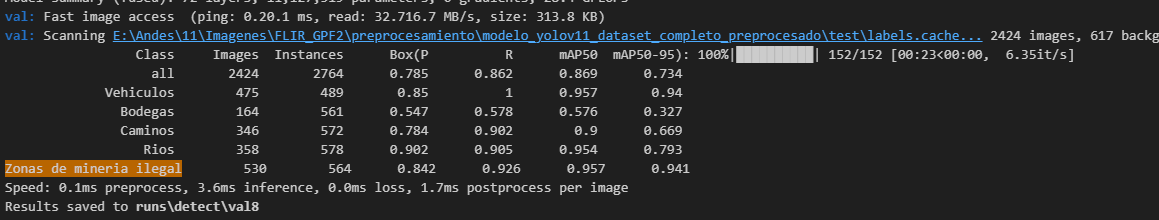

In [ ]:
("finetuning_resultados/finetuning_complete_preprocessed_dataset_v2/weights/best.pt", "preprocesamiento/modelo_yolov11_dataset_completo_preprocesado/dataset.yaml", "completo_preprocesado")

En cuanto al mejor modelo escodigo en general en su desempeño en todas las clases. Escogimos el del modelo del dataset filtrado sin preprocesamiento.

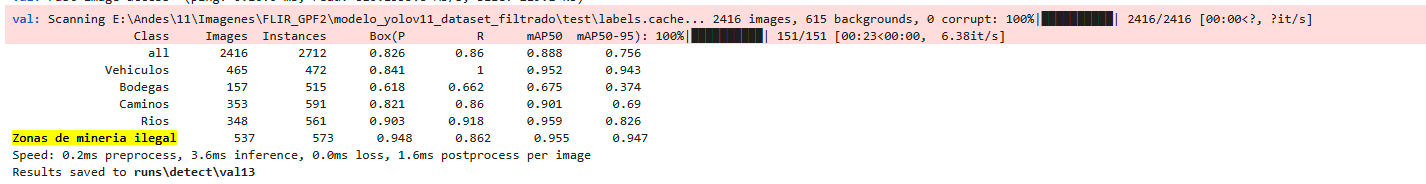

In [ ]:
("finetuning_resultados/finetuning_filtered_dataset_v2_freeze0/weights/best.pt", "modelo_yolov11_dataset_filtrado/dataset.yaml", "filtrado_freeze0")

In [ ]:
import os
import random
import matplotlib.pyplot as plt
from ultralytics import YOLO
import cv2

def show_predictions_minery_zone(model_path, dataset_path, class_index=4, count=25, imgsz=640, device=0):
    """
    Muestra un grid 5x5 con predicciones sobre imágenes que contienen la clase 'zonas de minería ilegal'.

    Args:
        model_path (str): Ruta al modelo YOLO entrenado (.pt).
        dataset_path (str): Ruta a la carpeta raíz del dataset (donde está /test/images y /test/labels).
        class_index (int): Índice de la clase "Zonas de minería ilegal".
        count (int): Número de imágenes a mostrar.
    """
    model = YOLO(model_path)

    labels_dir = os.path.join(dataset_path, 'test', 'labels')
    images_dir = os.path.join(dataset_path, 'test', 'images')

    matching_files = []
    for file in os.listdir(labels_dir):
        label_path = os.path.join(labels_dir, file)
        with open(label_path, 'r') as f:
            lines = f.readlines()
            if any(int(line.split()[0]) == class_index for line in lines):
                matching_files.append(file.replace('.txt', '.jpg'))

    selected_images = random.sample(matching_files, min(count, len(matching_files)))

    fig, axes = plt.subplots(5, 5, figsize=(18, 18))
    fig.suptitle("Predicciones sobre zonas de minería ilegal", fontsize=20)

    for ax, img_name in zip(axes.flat, selected_images):
        img_path = os.path.join(images_dir, img_name)
        results = model(img_path, imgsz=imgsz, device=device, verbose=False)
        pred_img = results[0].plot()

        # Convertir de BGR a RGB
        pred_img_rgb = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)

        ax.imshow(pred_img_rgb)
        ax.set_title(img_name, fontsize=8)
        ax.axis("off")
        
    plt.tight_layout()
    plt.savefig("grid_25_mineria.png", dpi=300)
    plt.show()



In [ ]:
show_predictions_minery_zone(
    model_path="finetuning_resultados/finetuning_complete_preprocessed_dataset_v2/weights/best.pt",
    dataset_path="preprocesamiento/modelo_yolov11_dataset_completo_preprocesado",
    class_index=4, 
    count=25,
    imgsz=640,
    device=0
)

In [ ]:
show_predictions_minery_zone(
    model_path="finetuning_resultados/finetuning_filtered_dataset_v2_freeze0/weights/best.pt",
    dataset_path="modelo_yolov11_dataset_filtrado",
    class_index=4, 
    count=25,
    imgsz=640,
    device=0
)